In [34]:
import struct
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
import os
from typing import Union, List, Optional


class MNISTLoader:
    def __init__(self, images_path, labels_path):
        # Verify files exist
        if not os.path.exists(images_path):
            raise FileNotFoundError(f"Images file not found at: {images_path}")
        if not os.path.exists(labels_path):
            raise FileNotFoundError(f"Labels file not found at: {labels_path}")
            
        self.images = self._read_images(images_path)
        self.labels = self._read_labels(labels_path)
        
    def _read_images(self, path):
        with open(path, 'rb') as f:
            # Read header info
            magic = struct.unpack('>I', f.read(4))[0]
            num_images = struct.unpack('>I', f.read(4))[0]
            num_rows = struct.unpack('>I', f.read(4))[0]
            num_cols = struct.unpack('>I', f.read(4))[0]
            
            # Read image data
            image_data = np.frombuffer(f.read(), dtype=np.uint8)
            image_data = image_data.reshape(num_images, 1, num_rows, num_cols)
            
            # Normalize to [0,1] range
            return image_data.astype(np.float32) / 255.0

    def _read_labels(self, path):
        with open(path, 'rb') as f:
            # Read header info
            magic = struct.unpack('>I', f.read(4))[0]
            num_labels = struct.unpack('>I', f.read(4))[0]
            
            # Read label data
            return np.frombuffer(f.read(), dtype=np.uint8)


class MNISTDataset(Dataset):
    def __init__(self, images, labels):
        self.images = torch.FloatTensor(images)
        self.labels = torch.LongTensor(labels)
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]


def load_mnist(train=True, batch_size=32, shuffle=True):
    """
    Load MNIST dataset from local files
    
    Args:
        train (bool): If True, load training data, else load test data
        batch_size (int): Size of batches to return
        shuffle (bool): Whether to shuffle the data
        
    Returns:
        DataLoader: PyTorch DataLoader object
    """
    base_path = r'D:\Programming\Python\PennyLane\TrainableParamaterisedQuantumCircuit\MNIST_Data'
    
    if train:
        images_path = os.path.join(base_path, 'train-images.idx3-ubyte')
        labels_path = os.path.join(base_path, 'train-labels.idx1-ubyte')
    else:
        images_path = os.path.join(base_path, 't10k-images.idx3-ubyte')
        labels_path = os.path.join(base_path, 't10k-labels.idx1-ubyte')
    
    # Load the data
    loader = MNISTLoader(images_path, labels_path)
    
    # Create dataset
    dataset = MNISTDataset(loader.images, loader.labels)
    
    # Create dataloader with more conservative settings
    return DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=0,
        pin_memory=True,
        persistent_workers=False,  # Disabled persistent workers
        prefetch_factor=None  # Removed prefetch
    )


def show_batch_images(images: torch.Tensor, 
                     labels: torch.Tensor, 
                     indices: Optional[Union[List[int], np.ndarray]] = None,
                     grid_size: tuple = (4, 4),
                     figsize: tuple = (12, 12)) -> None:
    """
    Display selected images from a batch of MNIST images.
    
    Args:
        images (torch.Tensor): Batch of images with shape [batch_size, channels, height, width]
        labels (torch.Tensor): Corresponding labels
        indices (list or np.ndarray, optional): Specific indices to display. If None, displays first n images that fit in grid
        grid_size (tuple): Size of the display grid (rows, cols)
        figsize (tuple): Figure size in inches (width, height)
        
    Returns:
        None (displays the plot)
    """
    # Ensure images are on CPU and convert to numpy if needed
    if images.device != 'cpu':
        images = images.cpu()
    if labels.device != 'cpu':
        labels = labels.cpu()
    
    # Calculate total spots in grid
    total_spots = grid_size[0] * grid_size[1]
    
    # If no indices provided, use first n images that fit in grid
    if indices is None:
        indices = list(range(min(total_spots, len(images))))
    else:
        # Ensure indices are within bounds
        indices = [i for i in indices if i < len(images)]
        if not indices:
            raise ValueError("No valid indices provided")
    
    # Create figure and axes
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=figsize)
    fig.suptitle('MNIST Digits from Batch', fontsize=16, y=0.95)
    
    # Flatten axes for easier indexing
    axes = axes.ravel()
    
    # Plot each selected image
    for idx, ax_idx in enumerate(range(total_spots)):
        ax = axes[ax_idx]
        
        if idx < len(indices):
            # Get image and label
            img = images[indices[idx]].squeeze()
            label = labels[indices[idx]].item()
            
            # Display image
            ax.imshow(img, cmap='gray')
            ax.set_title(f'Label: {label}')
        else:
            # Hide empty subplots
            ax.axis('off')
            continue
            
        # Remove ticks
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Adjust layout and display
    plt.tight_layout()
    plt.show()


class InceptionNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # 1->32: (batch,32,28,28)
            nn.ReLU(),
            nn.Conv2d(32, 16, kernel_size=1, padding=0)  # 32->16: (batch,16,28,28)
        )
        
        self.path1 = nn.Sequential(
            nn.Conv2d(16, 8, kernel_size=1)  # 16->8: (batch,8,28,28)
        )
        
        self.path2 = nn.Sequential(
            nn.Conv2d(16, 8, kernel_size=1),  # 16->8: bottleneck
            nn.Conv2d(8, 16, kernel_size=3, padding=1)  # 8->16: (batch,16,28,28)
        )
        
        self.path3 = nn.Sequential(
            nn.Conv2d(16, 8, kernel_size=1),  # 16->8: bottleneck
            nn.Conv2d(8, 16, kernel_size=5, padding=2)  # 8->16: (batch,16,28,28)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(40, 16, kernel_size=1),  # 40->16: (batch,16,28,28)
            nn.MaxPool2d(kernel_size=2, stride=2)  # (batch,16,14,14)
        )
        
        self.linears = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16 * 14 * 14, 128),  # Modified for pooled dimensions
            nn.ReLU(),
            nn.Linear(128, 10),
            nn.ReLU(), 
            nn.Linear(10, 10)
        )
        
    def forward(self, x):
        x = self.conv1(x)  # turns to multi-channel
        
        path1_out = self.path1(x) # 1x1
        path2_out = self.path2(x) # 1x1 -> 3x3
        path3_out = self.path3(x) # 1x1 -> 5x5
        
        x = torch.cat([path1_out, path2_out, path3_out], dim=1)  # (batch,40,28,28)
        
        x = self.conv2(x)  # (batch,16,14,14) after conv and pool
        
        x = self.linears(x)
        
        return x.softmax(dim=1)




In [35]:
# First check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = InceptionNet().to(device).double()


Using device: cuda


Batch 0
Images shape: torch.Size([128, 1, 28, 28])
Labels shape: torch.Size([128])


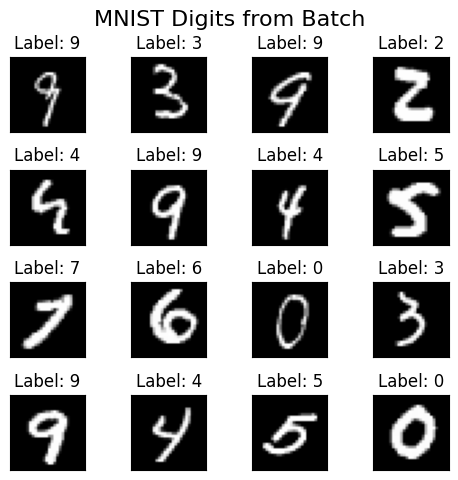

In [36]:

train_loader = load_mnist(train=True, batch_size=128, shuffle=True)
test_loader = load_mnist(train=False, batch_size=128, shuffle=False)

for batch_idx, (images, labels) in enumerate(train_loader):
    print(f"Batch {batch_idx}")
    print(f"Images shape: {images.shape}")  # Should be [batch_size, 1, 28, 28]
    print(f"Labels shape: {labels.shape}")  # Should be [batch_size]
    show_batch_images(images, labels, figsize=(5,5))
    break  # Just show first batch
      

In [37]:
optimiser = torch.optim.Adamax(model.parameters(), lr=0.01)
criterion = nn.MSELoss()
epochs = 5

for epoch in range(epochs):
    for batch_idx, (images, labels) in enumerate(train_loader):
        
        images = images.to(device).double()
        labels_one_hot = torch.nn.functional.one_hot(labels, 10).to(device).double()
        
        optimiser.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels_one_hot)
        loss.backward()
        optimiser.step()
        
        if epoch % 1 == 0:
            print(f'[Epoch {epoch + 1}] [Batch {batch_idx}] Loss: {loss.item():.5f}')
        
    

[Epoch 1] [Batch 0] Loss: 0.09005
[Epoch 1] [Batch 1] Loss: 0.09225
[Epoch 1] [Batch 2] Loss: 0.09113
[Epoch 1] [Batch 3] Loss: 0.09399
[Epoch 1] [Batch 4] Loss: 0.09687
[Epoch 1] [Batch 5] Loss: 0.09026
[Epoch 1] [Batch 6] Loss: 0.08791
[Epoch 1] [Batch 7] Loss: 0.08716
[Epoch 1] [Batch 8] Loss: 0.08512
[Epoch 1] [Batch 9] Loss: 0.08265
[Epoch 1] [Batch 10] Loss: 0.08294
[Epoch 1] [Batch 11] Loss: 0.08456
[Epoch 1] [Batch 12] Loss: 0.07811
[Epoch 1] [Batch 13] Loss: 0.07659
[Epoch 1] [Batch 14] Loss: 0.07317
[Epoch 1] [Batch 15] Loss: 0.06838
[Epoch 1] [Batch 16] Loss: 0.06266
[Epoch 1] [Batch 17] Loss: 0.06779
[Epoch 1] [Batch 18] Loss: 0.05861
[Epoch 1] [Batch 19] Loss: 0.04783
[Epoch 1] [Batch 20] Loss: 0.05651
[Epoch 1] [Batch 21] Loss: 0.05813
[Epoch 1] [Batch 22] Loss: 0.04430
[Epoch 1] [Batch 23] Loss: 0.04864
[Epoch 1] [Batch 24] Loss: 0.04801
[Epoch 1] [Batch 25] Loss: 0.04488
[Epoch 1] [Batch 26] Loss: 0.04962
[Epoch 1] [Batch 27] Loss: 0.04416
[Epoch 1] [Batch 28] Loss: 0.0

In [38]:
with torch.no_grad():
    total_correct = 0
    total_samples = 0
    total_loss = 0
    
    for batch_idx, (images, labels) in enumerate(test_loader):
        images = images.to(device).double()
        labels_one_hot = torch.nn.functional.one_hot(labels, 10).to(device).double()
        
        outputs = model(images)
        
        # Get predicted classes
        _, predicted = torch.max(outputs, dim=1)
        
        # Calculate batch accuracy
        correct = (predicted == labels.to(device)).sum().item()
        total = labels.size(0)
        batch_accuracy = 100 * correct / total
        
        # Accumulate totals
        total_correct += correct
        total_samples += total
        
        outputs_one_hot = torch.nn.functional.one_hot(predicted, 10).double()
        loss = criterion(outputs_one_hot, labels_one_hot)
        total_loss += loss.item()
        
        if epoch % 1 == 0:
            print(f'[Batch {batch_idx}] '
                  f'Loss: {loss.item():.5f} | '
                  f'Accuracy: {batch_accuracy:.2f}% '
                  f'({correct}/{total})')
    
    # Calculate overall metrics
    overall_accuracy = 100 * total_correct / total_samples
    average_loss = total_loss / (batch_idx + 1)
    
    print(f'\nOverall Results:')
    print(f'Average Loss: {average_loss:.5f}')
    print(f'Overall Accuracy: {overall_accuracy:.2f}% ({total_correct}/{total_samples})')

[Batch 0] Loss: 0.00313 | Accuracy: 98.44% (126/128)
[Batch 1] Loss: 0.00156 | Accuracy: 99.22% (127/128)
[Batch 2] Loss: 0.00469 | Accuracy: 97.66% (125/128)
[Batch 3] Loss: 0.00156 | Accuracy: 99.22% (127/128)
[Batch 4] Loss: 0.00469 | Accuracy: 97.66% (125/128)
[Batch 5] Loss: 0.00469 | Accuracy: 97.66% (125/128)
[Batch 6] Loss: 0.00313 | Accuracy: 98.44% (126/128)
[Batch 7] Loss: 0.00781 | Accuracy: 96.09% (123/128)
[Batch 8] Loss: 0.00313 | Accuracy: 98.44% (126/128)
[Batch 9] Loss: 0.01406 | Accuracy: 92.97% (119/128)
[Batch 10] Loss: 0.00469 | Accuracy: 97.66% (125/128)
[Batch 11] Loss: 0.00156 | Accuracy: 99.22% (127/128)
[Batch 12] Loss: 0.00313 | Accuracy: 98.44% (126/128)
[Batch 13] Loss: 0.00313 | Accuracy: 98.44% (126/128)
[Batch 14] Loss: 0.00313 | Accuracy: 98.44% (126/128)
[Batch 15] Loss: 0.00000 | Accuracy: 100.00% (128/128)
[Batch 16] Loss: 0.01094 | Accuracy: 94.53% (121/128)
[Batch 17] Loss: 0.00313 | Accuracy: 98.44% (126/128)
[Batch 18] Loss: 0.00313 | Accuracy: 